# 1. Problem Statement
The goal of this project is to identify potential customer churn using the UCI Online Retail dataset. Churn is defined based on customer purchasing inactivity over a defined time period. By analyzing transactional patterns, we aim to predict churn likelihood and suggest strategies to retain valuable customers.

_____

## 2. Dataset Understanding
##### ->Source: UCI Machine Learning Repository

##### ->Total Records: ~541,909 transactions

##### ->Key Features:
     .InvoiceNo: Unique invoice ID (starts with "C" if cancelled)
     .StockCode: Product ID
     .Description: Product description
     .Quantity: Number of units purchased
     .InvoiceDate: Purchase timestamp
     .UnitPrice: Price per unit
     .CustomerID: Unique customer identifier
     .Country: Customer location
     .Target Variable (engineered):
     .Churned: Binary label (1 = churned, 0 = active), derived by analyzing customer activity recency.

_____


## 3. Assumptions
##### . Churn is defined as a customer who has not made a purchase in the last 6 months.

##### . Canceled transactions (identified by InvoiceNo starting with “C”) are excluded from analysis.

##### . Missing CustomerID rows are removed as they can't be used for customer-level analysis.

_____


## 4. Data Cleaning Strategy
##### . Drop rows with null CustomerID or Description.

##### . Convert InvoiceDate to datetime format.

##### . Remove records with non-positive Quantity or UnitPrice.

##### . Filter out canceled transactions.

##### . Create a cleaned dataset suitable for customer-level aggregation.

_____


## 5. Exploratory Data Analysis (EDA)
##### . Number of unique customers.

##### . Churn distribution.

##### . RFM (Recency, Frequency, Monetary) feature distributions.

##### . Sales trends by month/country.

##### . Correlation matrix of engineered features.

##### . Top contributing products/countries to churn.

_____


## 6. Approach
#### A. Data Preprocessing

  ##### . Clean raw transactional data.

  ##### . Create RFM metrics per customer.

  ##### . Label customers as churned or active.

#### B. Feature Engineering

  ##### . RFM scores

  ##### . Time between purchases

  ##### . Total items bought

  ##### . Country encoded features

#### C. Modeling

  ##### . Train/Test split

  ##### . Use classification models (Logistic Regression, Random Forest, XGBoost)

  ##### . Use GridSearchCV for tuning

#### D. Evaluation

  ##### . Use accuracy, F1-score, ROC-AUC

  ##### . Confusion matrix for churn predictions

_____


## 7. Results and Business Insights
#### . Key features influencing churn: Recency, Frequency, Monetary Value

#### . High-value customers tend to churn less frequently.

#### . Customers from certain countries show higher churn tendencies.

#### . Recommendations:

   ##### > Create re-engagement campaigns for recent churn risks
   ##### > Offer personalized discounts for high-Monetary but low-Frequency customers
   ##### > Target top 20% RFM scorers with loyalty incentives

_____

In [14]:
! pip install ucimlrepo

In [19]:
! pip install openpyxl


In [31]:
# Import the libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")


# Fetch and load data
online_retail = fetch_ucirepo(id=352)
X = online_retail.data.features
id = online_retail.data.ids
data = pd.concat([id, X], axis=1)

# Quick look at data
data.head()
# could'nt use this dataset as ucimlrepo server was down at that time.

ConnectionError: Error connecting to server

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Load Dataset (Downloaded from Kaggle)

import pandas as pd
data = pd.read_csv("Online_Retail.csv.zip", encoding='ISO-8859-1', compression='zip')
print(data.head())



  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

    InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/10 8:26       2.55     17850.0  United Kingdom  
1  12/1/10 8:26       3.39     17850.0  United Kingdom  
2  12/1/10 8:26       2.75     17850.0  United Kingdom  
3  12/1/10 8:26       3.39     17850.0  United Kingdom  
4  12/1/10 8:26       3.39     17850.0  United Kingdom  


In [41]:
# Convert InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Handle missing values
data.dropna(subset=['CustomerID'], inplace=True)

# Filter out canceled transactions (InvoiceNo starting with 'C')
data = data[~data['InvoiceNo'].astype(str).str.startswith('C')]

# Remove negative or zero quantity/price
data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)]

# Feature: TotalPrice
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']


In [43]:
# Define the last purchase date
last_date = data['InvoiceDate'].max()

# Define churn: No purchase in the last 6 months
snapshot_date = last_date - pd.DateOffset(months=6)
last_purchase = data.groupby('CustomerID')['InvoiceDate'].max().reset_index()
last_purchase['Churned'] = last_purchase['InvoiceDate'] < snapshot_date

# Merge churn info back to main data
data = data.merge(last_purchase[['CustomerID', 'Churned']], on='CustomerID', how='left')


In [45]:
# Feature Engineering: RFM Metrics

rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (last_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Add Churned label
rfm = rfm.merge(last_purchase[['CustomerID', 'Churned']], on='CustomerID')


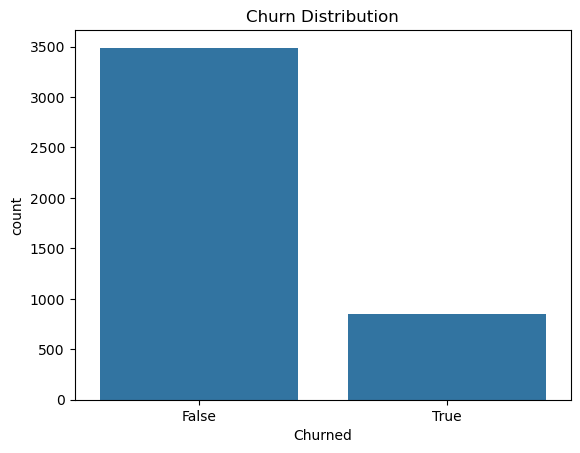

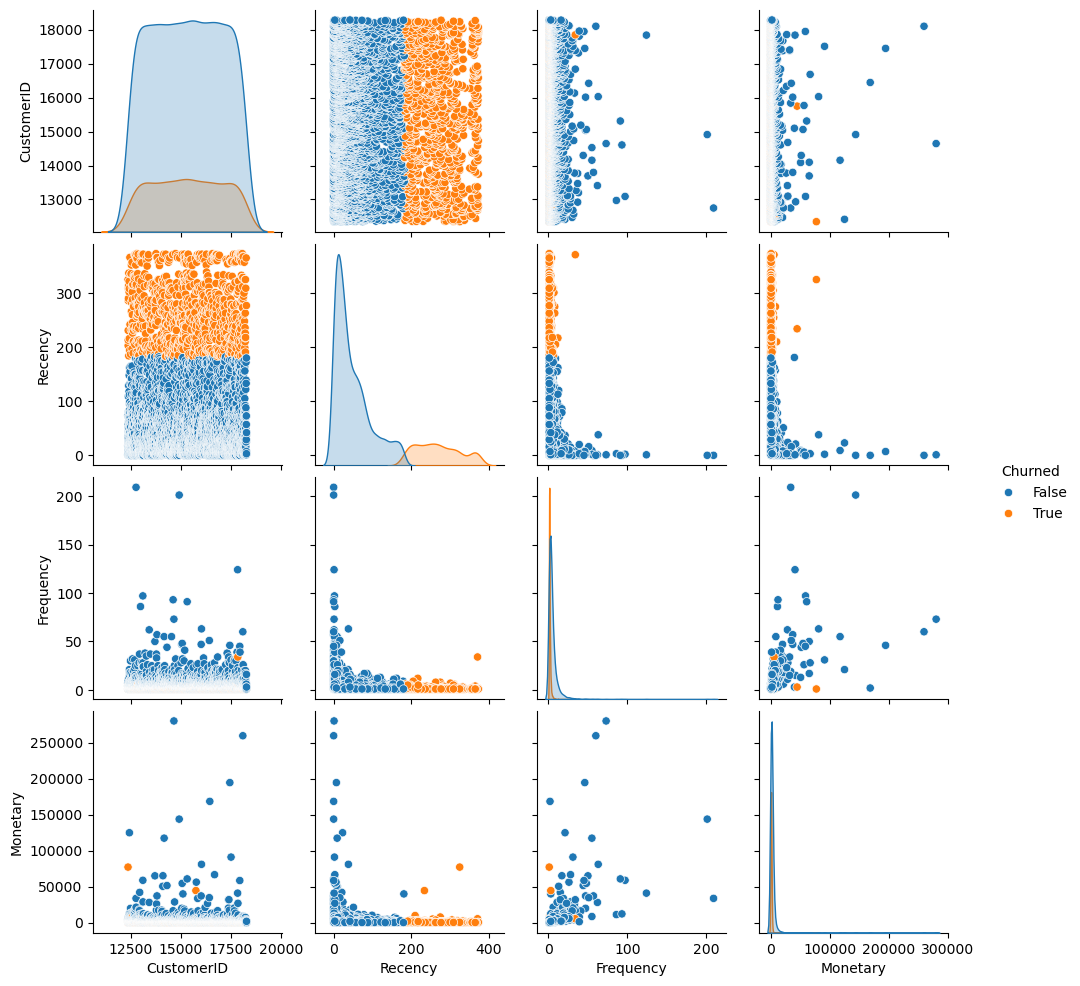

In [47]:
# EDA: Visualizing RFM Distributions

# Churn distribution
sns.countplot(x='Churned', data=rfm)
plt.title("Churn Distribution")
plt.show()

# Pairplot
sns.pairplot(rfm, hue='Churned')
plt.show()


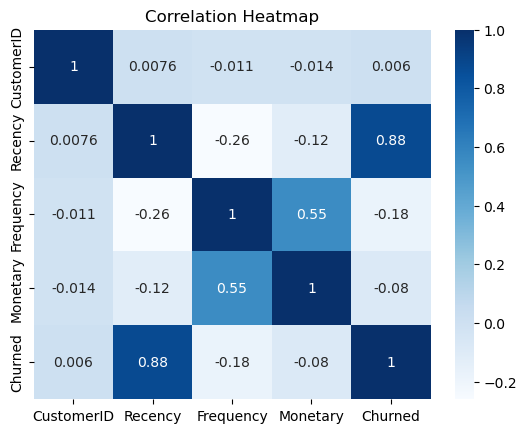

In [48]:
# Correlation Heatmap
sns.heatmap(rfm.corr(), annot=True, cmap='Blues')
plt.title('Correlation Heatmap')
plt.show()


In [49]:
# Modeling Churn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Prepare features and target
X = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['Churned']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Random Forest Model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[872   0]
 [  0 213]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       872
        True       1.00      1.00      1.00       213

    accuracy                           1.00      1085
   macro avg       1.00      1.00      1.00      1085
weighted avg       1.00      1.00      1.00      1085



### Example: Manually Test Your Model
##### . Let’s say you want to test your model on a new customer with the following profile:
       > Recency: 90 days ago (last purchase was 90 days ago)
       > Frequency: 5 invoices (made 5 purchases)
       > TotalItems: 25 items bought in total
       > AvgPrice: £3.5 per item

In [59]:
# Example input with correct feature names
# Test input with correct features only
example_customer = pd.DataFrame({
    'Recency': [90],
    'Frequency': [5],
    'Monetary': [100]
})


# Predict churn (0 = not churned, 1 = churned)
prediction = model.predict(example_customer)

# Show result
if prediction[0] == 1:
    print("🔴 The customer is likely to churn.")
else:
    print("🟢 The customer is likely to stay active.")


🟢 The customer is likely to stay active.


In [61]:
# Customer who buys frequently
test1 = pd.DataFrame({'Recency': [30], 'Frequency': [12], 'Monetary': [60]})
print("Prediction:", model.predict(test1))  # Expected: 0 (Active)

# Customer inactive for long
test2 = pd.DataFrame({'Recency': [250], 'Frequency': [2], 'Monetary': [10]})
print("Prediction:", model.predict(test2))  # Expected: 1 (Churned)


Prediction: [False]
Prediction: [ True]


### Business Insights
- Higher recency correlates with churn: Customers who haven't purchased recently are more likely to churn.
- Frequent and high-spending customers are less likely to churn.
- Focus on retention strategies for medium-spending and infrequent buyers.
